## Practical Approaches to Optimizng Budget in Marketing Mix Modeling using saturation curves and statistical models

Marketing Mix Modeling (MMM) is a data-driven approach used to analyze key drivers of business outcomes, like sales or revenue. It examines factors influencing responses to optimize marketing activities such as advertising, pricing, and promotions. MMM focuses on understanding the impact of marketing contributions, particularly advertising spend in various media channels, to provide insights on improving business performance. By evaluating the effectiveness of advertising spend, MMM helps identify the most impactful channels for increasing sales and revenue while suggesting adjustments or eliminations to maximize marketing ROI

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import math
import sys
import os


pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
#suppress exponential notation, define an appropriate float formatter
#specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18
import seaborn as sns

#from plotnine import *


#import plotly.io as pio
#pio.renderers.default = 'iframe' # or 'notebook' or 'colab' or 'jupyterlab'

In [3]:
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from fbprophet import Prophet
import optuna as opt
from functools import partial
from scipy import optimize

Importing plotly failed. Interactive plots will not work.


## Helper Functions

Adstock transformation is utilized to account for the delayed and diminishing effects of advertising on consumer behavior. In marketing mix modeling, both saturation curves and trained models can be employed to optimize budget allocation for advertising expenditure

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
class AdstockGeometric(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.5):
        self.alpha = alpha
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: np.ndarray):
        x_decayed = np.zeros_like(X)
        x_decayed[0] = X[0]
        
        for xi in range(1, len(x_decayed)):
            x_decayed[xi] = X[xi] + self.alpha * x_decayed[xi - 1]
        return x_decayed
    
    
class HillSaturation(BaseEstimator, TransformerMixin):
    def __init__(self, slope_s, half_saturation_k):
        self.slope_s = slope_s
        self.half_saturation_k = half_saturation_k
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: np.ndarray, x_point = None):
        
        self.half_saturation_k_transformed  = self.half_saturation_k * (np.max(X) - np.min(X)) + np.min(X)
        
        if x_point is None:
            return (1 + self.half_saturation_k_transformed**self.slope_s / X**self.slope_s)**-1
        
        #calculate y at x_point
        return (1 + self.half_saturation_k_transformed**self.slope_s / x_point**self.slope_s)**-1
            

## Data

The dataset consists of 208 weeks of revenue (from 2015 to 2019):

    5 media spend channels: tv_S, ooh_S, print_S, facebook_S, search_S
    2 media channels that have also the exposure information (Impression, Clicks): facebook_I, search_clicks_P (not used in this article)
    Organic media without spend: newsletter
    Control variables: events, holidays, competitor sales (competitor_sales_B)

In [5]:
data = pd.read_csv("Datasets/MMM_data/data_raw_2015-11-23__2019-11-11.csv", parse_dates = ["DATE"])
data.columns = [c.lower() if c in ["DATE"] else c for c in data.columns]
data

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2754371.66667,167687.60000,0,95463.66667,72903852.71259,0.00000,0,8125009,228213.98744,na,19401.65385
1,2015-11-30,2584276.66667,214600.90000,0,0.00000,16581099.54533,29511.71546,31000,7901549,34258.57351,na,14791.00000
2,2015-12-07,2547386.66667,0.00000,248022,3404.00000,49954773.67047,36132.35896,28400,8300197,127691.26133,na,14544.00000
3,2015-12-14,2875220.00000,625877.30000,0,132600.00000,31649297.02879,36804.21096,31900,8122883,84014.72031,na,2800.00000
4,2015-12-21,2215953.33333,0.00000,520005,0.00000,8802269.47875,28401.74407,27100,7105985,20687.47816,na,15478.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2456240.00000,0.00000,60433,153723.66667,0.00000,152840.32341,112100,7612762,0.00000,na,28157.00000
204,2019-10-21,2182825.00000,154917.60000,0,0.00000,56881962.23521,103680.04782,103700,6701667,133624.57552,na,10644.00000
205,2019-10-28,2377706.66667,21982.50000,14094,17476.00000,0.00000,138387.70414,114700,7688920,0.00000,na,9597.00000
206,2019-11-04,2732825.00000,22453.00000,0,24051.33333,0.00000,151707.99046,134100,8815710,0.00000,na,90189.00000


In [6]:
holidays = pd.read_csv("Datasets/MMM_data/prophet_holidays_daily.csv", parse_dates = ["ds"])
holidays["begin_week"] = holidays["ds"].dt.to_period('W-SUN').dt.start_time
#combine same week holidays into one holiday
holidays_weekly = holidays.groupby(["begin_week", "country", "year"], as_index = False).agg({'holiday':'#'.join, 'country': 'first', 'year': 'first'}).rename(columns = {'begin_week': 'ds'})
holidays_weekly_de = holidays_weekly.query("(country == 'DE')").copy()
holidays_weekly_de

,ds,holiday,country,year
12,1994-12-26,Neujahr,DE,1995
183,1995-04-10,Karfreitag,DE,1995
222,1995-04-17,Ostermontag,DE,1995
270,1995-05-01,Erster Mai,DE,1995
346,1995-05-22,Christi Himmelfahrt,DE,1995
...,...,...,...,...
35445,2044-05-23,Christi Himmelfahrt,DE,2044
35481,2044-06-06,Pfingstmontag,DE,2044
35646,2044-10-03,Tag der Deutschen Einheit,DE,2044
35781,2044-12-19,Erster Weihnachtstag,DE,2044


In [7]:
prophet_data = data.rename(columns = {'revenue': 'y', 'date': 'ds'})
#add categorical into prophet
prophet_data = pd.concat([prophet_data, pd.get_dummies(prophet_data["events"], drop_first = True, prefix = "events")], axis = 1)
prophet_data

,ds,y,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter,events_event2,events_na
0,2015-11-23,2754371.66667,167687.60000,0,95463.66667,72903852.71259,0.00000,0,8125009,228213.98744,na,19401.65385,0,1
1,2015-11-30,2584276.66667,214600.90000,0,0.00000,16581099.54533,29511.71546,31000,7901549,34258.57351,na,14791.00000,0,1
2,2015-12-07,2547386.66667,0.00000,248022,3404.00000,49954773.67047,36132.35896,28400,8300197,127691.26133,na,14544.00000,0,1
3,2015-12-14,2875220.00000,625877.30000,0,132600.00000,31649297.02879,36804.21096,31900,8122883,84014.72031,na,2800.00000,0,1
4,2015-12-21,2215953.33333,0.00000,520005,0.00000,8802269.47875,28401.74407,27100,7105985,20687.47816,na,15478.00000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2456240.00000,0.00000,60433,153723.66667,0.00000,152840.32341,112100,7612762,0.00000,na,28157.00000,0,1
204,2019-10-21,2182825.00000,154917.60000,0,0.00000,56881962.23521,103680.04782,103700,6701667,133624.57552,na,10644.00000,0,1
205,2019-10-28,2377706.66667,21982.50000,14094,17476.00000,0.00000,138387.70414,114700,7688920,0.00000,na,9597.00000,0,1
206,2019-11-04,2732825.00000,22453.00000,0,24051.33333,0.00000,151707.99046,134100,8815710,0.00000,na,90189.00000,0,1


In [8]:
prophet = Prophet(yearly_seasonality=True, holidays=holidays_weekly_de)
prophet.add_regressor(name = "events_event2")
prophet.add_regressor(name = "events_na")

In [9]:
prophet.fit(prophet_data[["ds", "y", "events_event2", "events_na"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y", "events_event2", "events_na"]])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


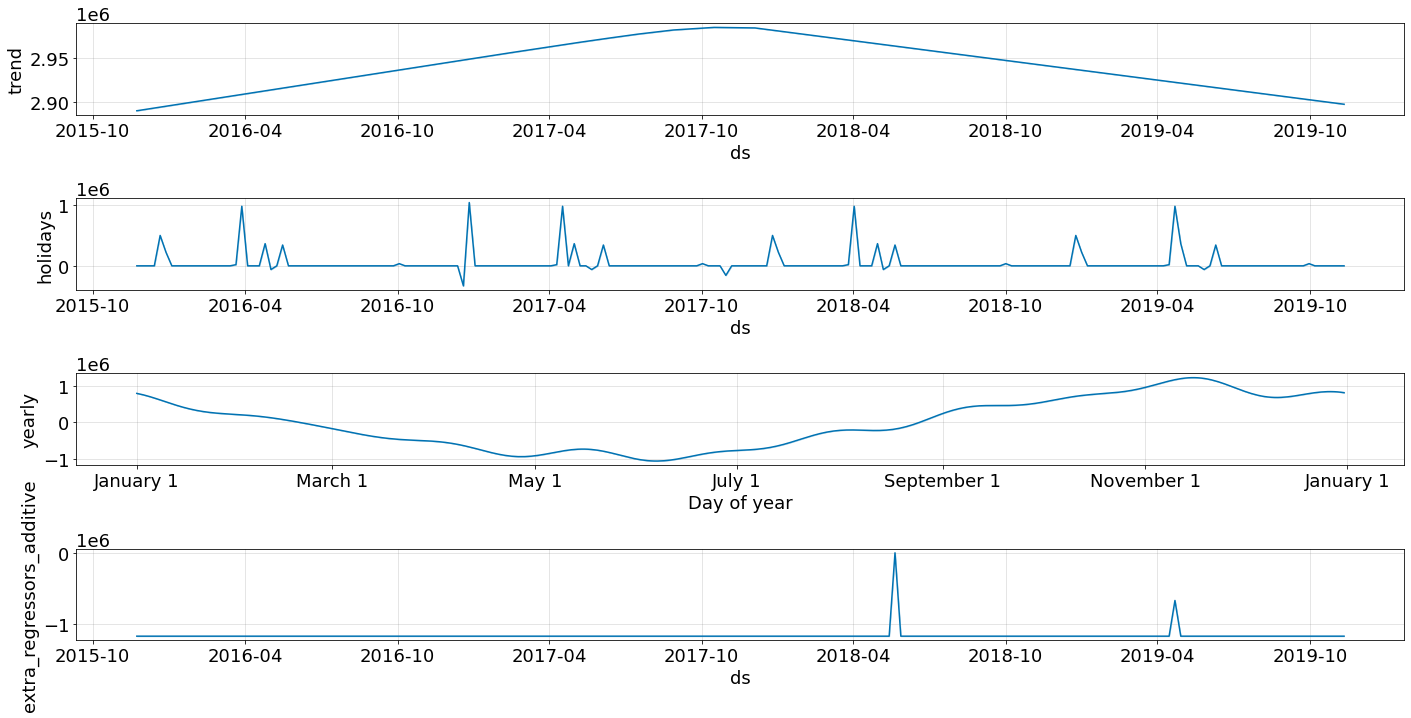

In [10]:
plot = prophet.plot_components(prophet_predict, figsize = (20, 10))

In [11]:
prophet_columns = [col for col in prophet_predict.columns if (col.endswith("upper") == False) & (col.endswith("lower") == False)]
events_numeric = prophet_predict[prophet_columns].filter(like = "events_").sum(axis = 1)


final_data = data.copy()
final_data["trend"] = prophet_predict["trend"]
final_data["season"] = prophet_predict["yearly"]
final_data["holiday"] = prophet_predict["holidays"]
final_data["events"] = (events_numeric - np.min(events_numeric)).values

In [12]:
data = final_data.copy()

## Modeling

In [13]:
def optuna_trial(trial, 
                 data:pd.DataFrame, 
                 target, 
                 features, 
                 adstock_features, 
                 adstock_features_params, 
                 hill_slopes_params, 
                 hill_half_saturations_params, 
                 tscv):
    
    data_temp = data.copy()
    adstock_alphas = {}
    hill_slopes = {}
    hill_half_saturations = {}
    
    for feature in adstock_features:
        adstock_param = f"{feature}_adstock"
        min_, max_ = adstock_features_params[adstock_param]
        adstock_alpha = trial.suggest_float(f"adstock_alpha_{feature}", min_, max_)
        adstock_alphas[feature] = adstock_alpha
        
        hill_slope_param = f"{feature}_hill_slope"
        min_, max_ = hill_slopes_params[hill_slope_param]
        hill_slope = trial.suggest_float(f"hill_slope_{feature}", min_, max_)
        hill_slopes[feature] = hill_slope
        
        hill_half_saturation_param = f"{feature}_hill_half_saturation"
        min_, max_ = hill_half_saturations_params[hill_half_saturation_param]
        hill_half_saturation = trial.suggest_float(f"hill_half_saturation_{feature}", min_, max_)
        hill_half_saturations[feature] = hill_half_saturation
        
        
        #adstock transformation
        x_feature = data[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        
        #hill saturation transformation
        temp_hill_saturation = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).fit_transform(temp_adstock)
        data_temp[feature] = temp_hill_saturation
        
        
    #Ridge parameters
    ridge_alpha = trial.suggest_float("ridge_alpha", 0.01, 10000)
    scores = []
    
    #cross validation
    for train_index, test_index in tscv.split(data_temp):
        x_train = data_temp.iloc[train_index][features]
        y_train =  data_temp[target].values[train_index]
        
        x_test = data_temp.iloc[test_index][features]
        y_test = data_temp[target].values[test_index]
        
        #params of Ridge Regression
        params = {"alpha": ridge_alpha}
        
        ridge = linear_model.Ridge(alpha = ridge_alpha, random_state=0)
        ridge.fit(x_train, y_train)
        prediction = ridge.predict(x_test)
        
        rmse = mean_squared_error(y_true = y_test, y_pred = prediction, squared = False)
        scores.append(rmse)
        
        
    trial.set_user_attr("scores", scores)
    
    trial.set_user_attr("params", params)
    trial.set_user_attr("adstock_alphas", adstock_alphas)
    trial.set_user_attr("hill_slopes", hill_slopes)
    trial.set_user_attr("hill_half_saturations", hill_half_saturations)
    
    
    #average of all scores    
    return np.mean(scores)

In [14]:
def optuna_optimize(trials, 
                    data: pd.DataFrame, 
                    target, 
                    features, 
                    adstock_features, 
                    adstock_features_params, 
                    hill_slopes_params, 
                    hill_half_saturations_params, 
                    tscv, 
                    seed = 42):
    print(f"data size: {len(data)}")
    
    print(f"adstock features: {adstock_features}")
    print(f"features: {features}")

    opt.logging.set_verbosity(opt.logging.WARNING) 
    
    
    study_mmm = opt.create_study(direction='minimize', sampler = opt.samplers.TPESampler(seed=seed))  
        
    optimization_function = partial(optuna_trial, 
                                    data = data, 
                                    target = target, 
                                    features = features, 
                                    adstock_features = adstock_features, 
                                    adstock_features_params = adstock_features_params, 
                                    hill_slopes_params = hill_slopes_params, 
                                    hill_half_saturations_params = hill_half_saturations_params, 
                                    tscv = tscv, 
                                    )
    
    
    study_mmm.optimize(optimization_function, n_trials = trials, show_progress_bar = True)
    
    return study_mmm

## Features and parameters

In [15]:
target = "revenue"
media_channels = ["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"]
organic_channels = ["newsletter"]
control_features = ["trend", "season", "holiday", "competitor_sales_B", "events"]
features = control_features + media_channels + organic_channels


tscv = TimeSeriesSplit(n_splits=2, test_size = 5)

adstock_features_params = {}
adstock_features_params["tv_S_adstock"] = (0.3, 0.8)
adstock_features_params["ooh_S_adstock"] = (0.1, 0.4)
adstock_features_params["print_S_adstock"] = (0.1, 0.4)
adstock_features_params["facebook_S_adstock"] = (0.1, 0.4)
adstock_features_params["search_S_adstock"] = (0.1, 0.3)
adstock_features_params["newsletter_adstock"] = (0.1, 0.4)

hill_slopes_params = {}
hill_slopes_params["tv_S_hill_slope"] = (0.1, 5.0)
hill_slopes_params["ooh_S_hill_slope"] = (0.1, 5.0)
hill_slopes_params["print_S_hill_slope"] = (0.1, 5.0)
hill_slopes_params["facebook_S_hill_slope"] = (0.1, 5.0)
hill_slopes_params["search_S_hill_slope"] = (0.1, 5.0)
hill_slopes_params["newsletter_hill_slope"] = (0.1, 5.0)

hill_half_saturations_params = {}
hill_half_saturations_params["tv_S_hill_half_saturation"] = (0.1, 1.0)
hill_half_saturations_params["ooh_S_hill_half_saturation"] = (0.1, 1.0)
hill_half_saturations_params["print_S_hill_half_saturation"] = (0.1, 1.0)
hill_half_saturations_params["facebook_S_hill_half_saturation"] = (0.1, 1.0)
hill_half_saturations_params["search_S_hill_half_saturation"] = (0.1, 1.0)
hill_half_saturations_params["newsletter_hill_half_saturation"] = (0.1, 1.0)

OPTUNA_TRIALS = 2000
experiment = optuna_optimize(trials = OPTUNA_TRIALS, 
                             data = data, 
                             target = target, 
                             features = features, 
                             adstock_features = media_channels + organic_channels, 
                             adstock_features_params = adstock_features_params, 
                             hill_slopes_params = hill_slopes_params,
                             hill_half_saturations_params = hill_half_saturations_params,
                             tscv = tscv)

C:\Users\raviteja.kurva\AppData\Roaming\Python\Python38\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


data size: 208
adstock features: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
features: ['trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']


  0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\RAVITE~1.KUR\AppData\Local\Temp/ipykernel_24516/3344362703.py:31: RuntimeWarning: divide by zero encountered in true_divide
  return (1 + self.half_saturation_k_transformed**self.slope_s / X**self.slope_s)**-1
C:\Users\RAVITE~1.KUR\AppData\Local\Temp/ipykernel_24516/3344362703.py:31: RuntimeWarning: divide by zero encountered in true_divide
  return (1 + self.half_saturation_k_transformed**self.slope_s / X**self.slope_s)**-1
C:\Users\RAVITE~1.KUR\AppData\Local\Temp/ipykernel_24516/3344362703.py:31: RuntimeWarning: divide by zero encountered in true_divide
  return (1 + self.half_saturation_k_transformed**self.slope_s / X**self.slope_s)**-1
C:\Users\RAVITE~1.KUR\AppData\Local\Temp/ipykernel_24516/3344362703.py:31: RuntimeWarning: divide by zero encountered in true_divide
  return (1 + self.half_saturation_k_transformed**self.slope_s / X**self.slope_s)**-1
  0%|          | 4/2000 [00:00<00:55, 35.82it/s]C:\Users\RAVITE~1.KUR\AppData\Local\

In [16]:
np.mean(experiment.best_trial.user_attrs["scores"])

22436.775179172808

In [17]:
experiment.best_trial.user_attrs["scores"]

[18004.297574234668, 26869.25278411095]

In [18]:
#ridge regression param
experiment.best_trial.user_attrs["params"]

{'alpha': 3.5124412970055676}

In [19]:
experiment.best_trial.user_attrs["adstock_alphas"]

{'tv_S': 0.33991013367946254,
 'ooh_S': 0.3921876135017767,
 'print_S': 0.2941202914360221,
 'facebook_S': 0.366565392117902,
 'search_S': 0.23854571538491792,
 'newsletter': 0.20812048772349295}

In [20]:
experiment.best_trial.user_attrs["hill_slopes"]

{'tv_S': 4.2931188232592286,
 'ooh_S': 2.2725526700406413,
 'print_S': 2.196030975907557,
 'facebook_S': 1.293484140496705,
 'search_S': 4.082014000490807,
 'newsletter': 4.314568851376739}

In [21]:
experiment.best_trial.user_attrs["hill_half_saturations"]

{'tv_S': 0.13890878303803125,
 'ooh_S': 0.7170422647403772,
 'print_S': 0.23914939017559164,
 'facebook_S': 0.7625292193616897,
 'search_S': 0.5200927553940573,
 'newsletter': 0.4492467917726849}

## Model Refit

In [22]:
def model_refit(data, 
                target, 
                features, 
                media_channels, 
                organic_channels, 
                model_params, 
                adstock_params, 
                hill_slopes_params,
                hill_half_saturations_params,
                start_index, 
                end_index):
    data_refit = data.copy()

    best_params = model_params

    adstock_alphas = adstock_params

    
    #apply adstock transformation
    
    temporal_features = [feature if feature not in media_channels and feature not in organic_channels else f"{feature}_hill" for feature in features]
    
    for feature in media_channels + organic_channels:
        adstock_alpha = adstock_alphas[feature]
        print(f"applying geometric adstock transformation on {feature} with alpha {adstock_alpha:0.3}") 

        #adstock transformation
        x_feature = data_refit[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        
        hill_slope = hill_slopes_params[feature]
        hill_half_saturation = hill_half_saturations_params[feature]
        print(f"applying saturation hill transformation on {feature} with saturation slope {hill_slope:0.3} and half saturation {hill_half_saturation:0.3}")
        
        temp_hill_saturation = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).fit_transform(temp_adstock)
        data_refit[f"{feature}_adstock"] = temp_adstock
        data_refit[f"{feature}_hill"] = temp_hill_saturation

    #build the final model on the data until the end analysis index
    x_input = data_refit.iloc[0:end_index][temporal_features].copy()
    y_true_all = data[target].values[0:end_index]

    #build ridge using the best parameters
    model = linear_model.Ridge(random_state=0, **best_params)
    model.fit(x_input, y_true_all) 


    #concentrate on the analysis interval
    y_true_interval = y_true_all[start_index:end_index]
    #transformed data
    x_input_interval_transformed = x_input.iloc[start_index:end_index]

    #revenue prediction for the analysis interval
    print(f"predicting {len(x_input_interval_transformed)} instances")
    prediction = model.predict(x_input_interval_transformed)

    #non transformed data set for the analysis interval 
    x_input_interval_nontransformed = data.iloc[start_index:end_index]

    
    return {
            'x_input_interval_nontransformed': x_input_interval_nontransformed, 
            'x_input_interval_transformed' : x_input_interval_transformed,
            'prediction_interval': prediction, 
            'y_true_interval': y_true_interval,
            "model": model,
            "model_train_data": x_input,
            "model_data": data_refit, 
            "model_features": temporal_features, 
            "features": features
           }
    

In [23]:
best_params = experiment.best_trial.user_attrs["params"]
adstock_params_best = experiment.best_trial.user_attrs["adstock_alphas"]
hill_slopes_params_best = experiment.best_trial.user_attrs["hill_slopes"]
hill_half_saturations_params_best = experiment.best_trial.user_attrs["hill_half_saturations"]

result = model_refit(data = data, 
                     target = target,
                     features = features, 
                     media_channels = media_channels, 
                     organic_channels = organic_channels, 
                     model_params = best_params, 
                     adstock_params = adstock_params_best, 
                     hill_slopes_params=hill_slopes_params_best,
                     hill_half_saturations_params=hill_half_saturations_params_best,
                     start_index = 0, 
                     end_index = data.shape[0])

applying geometric adstock transformation on tv_S with alpha 0.34
applying saturation hill transformation on tv_S with saturation slope 4.29 and half saturation 0.139
applying geometric adstock transformation on ooh_S with alpha 0.392
applying saturation hill transformation on ooh_S with saturation slope 2.27 and half saturation 0.717
applying geometric adstock transformation on print_S with alpha 0.294
applying saturation hill transformation on print_S with saturation slope 2.2 and half saturation 0.239
applying geometric adstock transformation on facebook_S with alpha 0.367
applying saturation hill transformation on facebook_S with saturation slope 1.29 and half saturation 0.763
applying geometric adstock transformation on search_S with alpha 0.239
applying saturation hill transformation on search_S with saturation slope 4.08 and half saturation 0.52
applying geometric adstock transformation on newsletter with alpha 0.208
applying saturation hill transformation on newsletter with sat

C:\Users\RAVITE~1.KUR\AppData\Local\Temp/ipykernel_24516/3344362703.py:31: RuntimeWarning: divide by zero encountered in true_divide
  return (1 + self.half_saturation_k_transformed**self.slope_s / X**self.slope_s)**-1


In [24]:
#different parameters
result.keys()

dict_keys(['x_input_interval_nontransformed', 'x_input_interval_transformed', 'prediction_interval', 'y_true_interval', 'model', 'model_train_data', 'model_data', 'model_features', 'features'])

In [25]:
#features used during modeling
result["model_features"]

['trend',
 'season',
 'holiday',
 'competitor_sales_B',
 'events',
 'tv_S_hill',
 'ooh_S_hill',
 'print_S_hill',
 'facebook_S_hill',
 'search_S_hill',
 'newsletter_hill']

In [26]:
result["model"].intercept_

-2253311.549391874

In [27]:
#save feature coefficients 
feature_coefficients = {}
for feature, model_feature, coef in zip(result["features"], result["model_features"], result["model"].coef_):
    feature_coefficients[feature] = coef
    print(f"feature: {feature} -> coefficient {coef}")

feature: trend -> coefficient 0.8337969166426888
feature: season -> coefficient 0.1290691990676452
feature: holiday -> coefficient 0.9963489302216846
feature: competitor_sales_B -> coefficient 0.26438731122059017
feature: events -> coefficient 1.0712407617516282
feature: tv_S -> coefficient 174638.97259910346
feature: ooh_S -> coefficient 79919.03697749857
feature: print_S -> coefficient 95187.76347556351
feature: facebook_S -> coefficient 44198.79410541945
feature: search_S -> coefficient 19817.87802702699
feature: newsletter -> coefficient 62087.86743502245


In [28]:
#data used for modeling
result["model_data"].head()

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,...,ooh_S_adstock,ooh_S_hill,print_S_adstock,print_S_hill,facebook_S_adstock,facebook_S_hill,search_S_adstock,search_S_hill,newsletter_adstock,newsletter_hill
0,2015-11-23,2754371.66667,167687.60000,0,95463.66667,72903852.71259,0.00000,0,8125009,228213.98744,...,0,0.00000,95463.66667,0.73444,228213.98744,0.35583,0,0.00000,19401.65385,0.01490
1,2015-11-30,2584276.66667,214600.90000,0,0.00000,16581099.54533,29511.71546,31000,7901549,34258.57351,...,0,0.00000,28077.80146,0.15840,117913.92330,0.19037,31000,0.01388,18828.88166,0.01312
2,2015-12-07,2547386.66667,0.00000,248022,3404.00000,49954773.67047,36132.35896,28400,8300197,127691.26133,...,248022,0.08968,11662.25115,0.02661,170914.42487,0.27538,35794,0.02470,18462.67603,0.01207
3,2015-12-14,2875220.00000,625877.30000,0,132600.00000,31649297.02879,36804.21096,31900,8122883,84014.72031,...,97271,0.01160,136030.10471,0.85753,146666.03348,0.23769,40438,0.04000,6642.46114,0.00015
4,2015-12-21,2215953.33333,0.00000,520005,0.00000,8802269.47875,28401.74407,27100,7105985,20687.47816,...,558153,0.38361,40009.21404,0.29059,74450.17023,0.11482,36746,0.02741,16860.43225,0.00819


In [29]:
mape_final= mean_absolute_percentage_error(result["y_true_interval"], result["prediction_interval"])
print(f"MAPE: {mape_final:0.3}")

MAPE: 0.0487


In [34]:
from plotnine import * 

def plot_spend_response_curve(channel, spend_response_df, average_spend = 0, average_response = 0, optimized_spend = None, optimized_response = None, figure_size = (15, 6)):
    average_spend_response_df = pd.DataFrame({
                                              'average_spend': [average_spend], 
                                              'average_response': [average_response]
                                             })
    plt = ggplot(spend_response_df, aes("spend", "response")) + geom_line()\
    + xlab("Spend (with adstock effect)") + ylab("Response")\
    + geom_point(data = average_spend_response_df, mapping = aes(x = "average_spend", y = "average_response"), size = 3, color = "blue")\
    + geom_vline(data = average_spend_response_df, mapping = aes(xintercept = "average_spend"), linetype='dotted', alpha = 0.5)\
    + geom_hline(data = average_spend_response_df, mapping = aes(yintercept = "average_response"), linetype='dotted', alpha = 0.5)\
     + theme(figure_size = figure_size,
                        legend_direction='horizontal', 
                        legend_position= "bottom",
                        legend_box_spacing=0.3,
                        legend_key_size=20, 
                        legend_entry_spacing_y=10, 
                        axis_text_y=element_text(weight="bold", size = 10)
            ) 
    
    

    if optimized_spend is not None and optimized_response is not None:
        optimized_spend_response_df = pd.DataFrame({'optimized_spend': [optimized_spend], 'optimized_response': [optimized_response]})
        plt = plt + geom_point(data = optimized_spend_response_df, mapping = aes(x = "optimized_spend", y = "optimized_response"), size = 4, color = "green")\
            + geom_vline(data = optimized_spend_response_df, mapping = aes(xintercept = "optimized_spend"), linetype='dotted', alpha = 0.5, color = "green")\
            + geom_hline(data = optimized_spend_response_df, mapping = aes(yintercept = "optimized_response"), linetype='dotted', alpha = 0.5, color = "green")\
              + ggtitle(f"{channel}: Response curve, mean and optimized spend\nAverage Spend: {average_spend}\nAverage Response: {average_response:0.3f}\nOptimized Spend: {optimized_spend:0.3f}\nOptimized Response: {optimized_response:0.3f}")
    else:
        plt = plt + ggtitle(f"{channel}: Response curve and mean spend\nAverage Spend: {average_spend}\nAverage Response: {average_response:0.3f}")
        
    return plt


def plot_multiple_spend_response_curves(spend_response_df, figure_size = (15, 6)):
    plt = ggplot(spend_response_df, aes("spend", "response", color = "media_channel")) + geom_line()\
        + xlab("Spend (with adstock effect)") + ggtitle("Response curves")\
        + theme(figure_size = figure_size,
                        legend_direction='vertical', 
                        legend_position= "right",
                        legend_box_spacing=0.6,
                        legend_key_size=20, 
                        legend_entry_spacing_y=10, 
                        axis_text_y=element_text(weight="bold", size = 10)
            ) 
    
    return plt

In [35]:
feature_coefficients

{'trend': 0.8337969166426888,
 'season': 0.1290691990676452,
 'holiday': 0.9963489302216846,
 'competitor_sales_B': 0.26438731122059017,
 'events': 1.0712407617516282,
 'tv_S': 174638.97259910346,
 'ooh_S': 79919.03697749857,
 'print_S': 95187.76347556351,
 'facebook_S': 44198.79410541945,
 'search_S': 19817.87802702699,
 'newsletter': 62087.86743502245}

tv_S
	tv_S: adstock: 0.33991013367946254
	tv_S: saturation slope: 4.2931188232592286
	tv_S: half saturation k: 0.13890878303803125
	tv_S: coefficient: 174638.97259910346
	average spend: 111327, avergae non-zero spend: 251697, min spend: 0.0, max spend: 1185349.3
	average response corresponding to the average non zero spending: 26918.608710592307


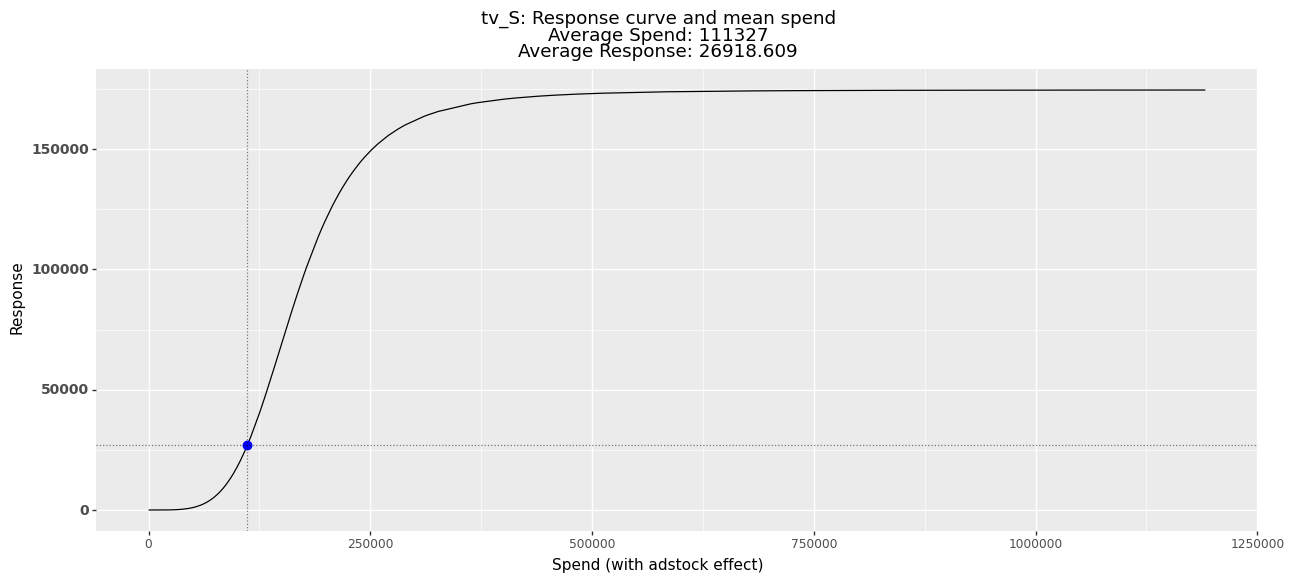


ooh_S
	ooh_S: adstock: 0.3921876135017767
	ooh_S: saturation slope: 2.2725526700406413
	ooh_S: half saturation k: 0.7170422647403772
	ooh_S: coefficient: 79919.03697749857
	average spend: 81033, avergae non-zero spend: 198294, min spend: 0, max spend: 938178
	average response corresponding to the average non zero spending: 614.7934424881807


C:\Users\RAVITE~1.KUR\AppData\Local\Temp/ipykernel_24516/3344362703.py:31: RuntimeWarning: divide by zero encountered in true_divide


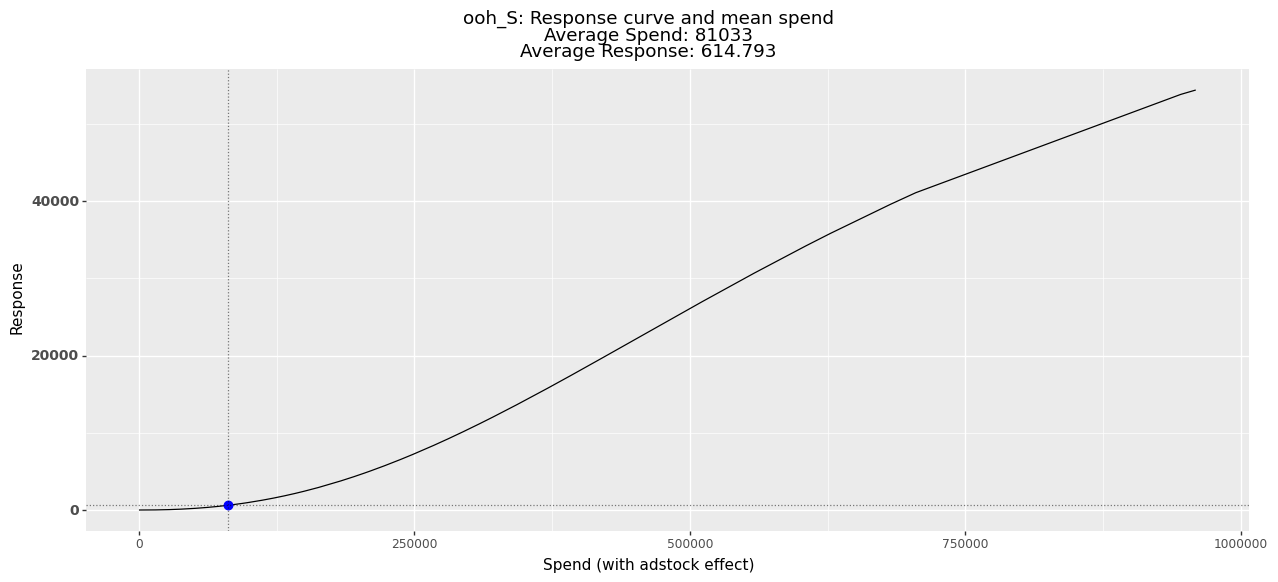


print_S
	print_S: adstock: 0.2941202914360221
	print_S: saturation slope: 2.196030975907557
	print_S: half saturation k: 0.23914939017559164
	print_S: coefficient: 95187.76347556351
	average spend: 27964, avergae non-zero spend: 66858, min spend: 0.0, max spend: 239417.333333333
	average response corresponding to the average non zero spending: 14964.956949692196


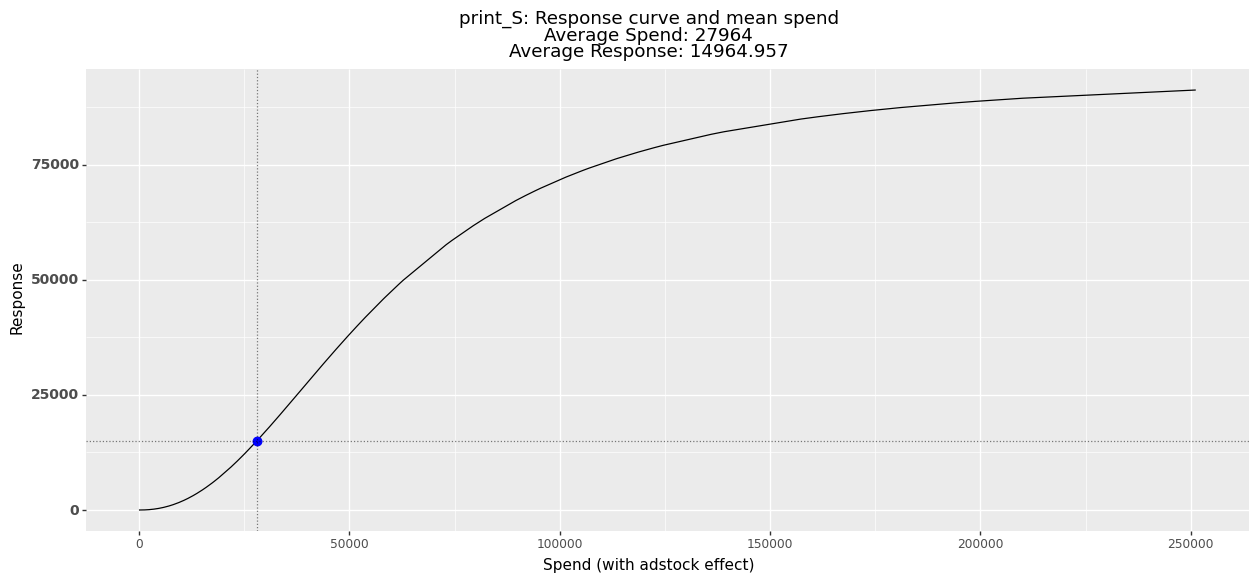


facebook_S
	facebook_S: adstock: 0.366565392117902
	facebook_S: saturation slope: 1.293484140496705
	facebook_S: half saturation k: 0.7625292193616897
	facebook_S: coefficient: 44198.79410541945
	average spend: 64369, avergae non-zero spend: 132563, min spend: 0.0, max spend: 462011.742240227
	average response corresponding to the average non zero spending: 4288.837168746324


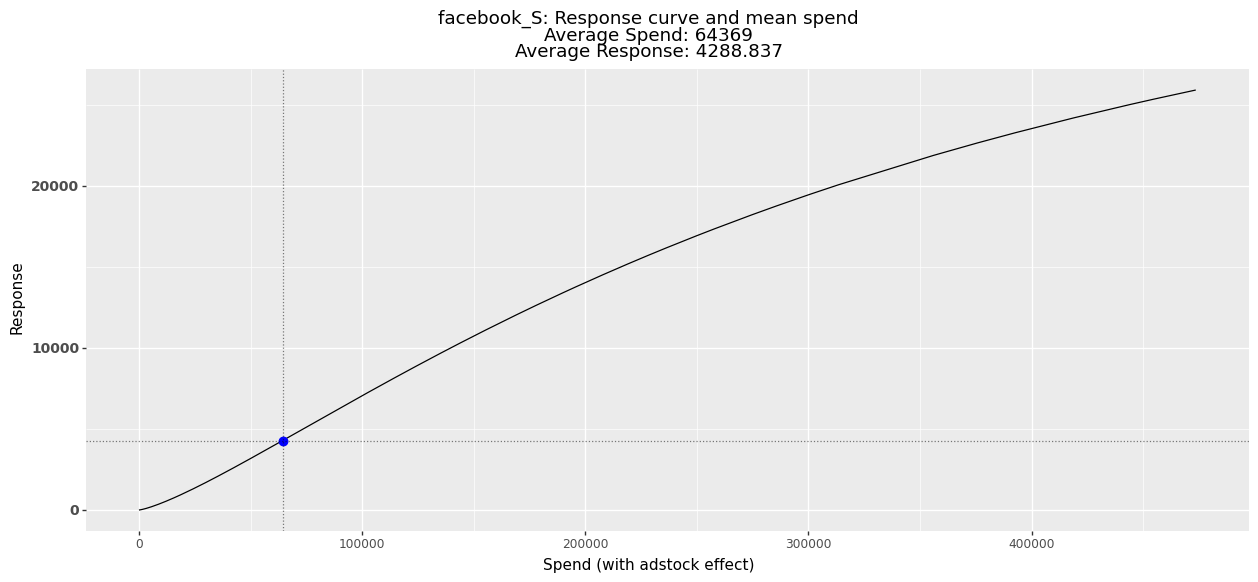


search_S
	search_S: adstock: 0.23854571538491792
	search_S: saturation slope: 4.082014000490807
	search_S: half saturation k: 0.5200927553940573
	search_S: coefficient: 19817.87802702699
	average spend: 44366, avergae non-zero spend: 52432, min spend: 0, max spend: 134100
	average response corresponding to the average non zero spending: 1136.3830835119968


C:\Users\RAVITE~1.KUR\AppData\Local\Temp/ipykernel_24516/3344362703.py:31: RuntimeWarning: divide by zero encountered in true_divide


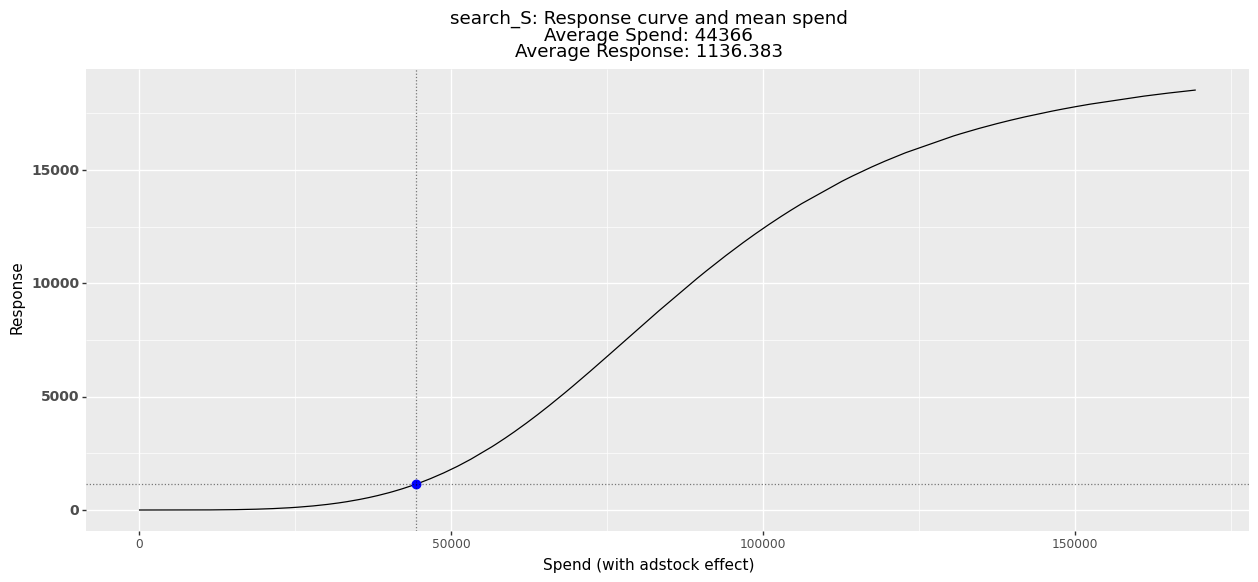

In [36]:
#dataframe for budget allocation
media_spend_response_data = []

#holds spend and response time series along with average spend/response for plotting spend-response curve
spend_response_curve_dict = {}

for media_channel in media_channels:
    print(media_channel)
    
    adstock = adstock_params_best[media_channel]
    print(f"\t{media_channel}: adstock: {adstock}")

    hill_slope = hill_slopes_params_best[media_channel]
    hill_half_saturation = hill_half_saturations_params_best[media_channel]
    print(f"\t{media_channel}: saturation slope: {hill_slope}")
    print(f"\t{media_channel}: half saturation k: {hill_half_saturation}")

    coef = feature_coefficients[media_channel]
    print(f"\t{media_channel}: coefficient: {coef}")
    ######################################################

    #loc returns end index inclusive
    spendings = result["model_data"][media_channel].values
    average_nonzero_spending = int(spendings[spendings > 0].mean())
    average_spending = int(spendings.mean())
    print(f"\taverage spend: {average_spending}, avergae non-zero spend: {average_nonzero_spending}, min spend: {spendings.min()}, max spend: {spendings.max()}")

    spendings_adstocked = AdstockGeometric(alpha = adstock).fit_transform(spendings)
    
    #we have to use the same data that we used for training for proper mapping of the average spending
    average_response = coef * HillSaturation(slope_s=hill_slope, half_saturation_k=hill_half_saturation).transform(X = spendings_adstocked, x_point = average_spending)
    print(f"\taverage response corresponding to the average non zero spending: {average_response}")

    #numpy array returns end index exclusive
    spendings_saturated = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).fit_transform(spendings_adstocked)
    
    response = spendings_saturated * coef  

    spend_response_temp_df = pd.DataFrame({'spend': spendings_adstocked, 'response': response, "media_channel": media_channel})

    media_spend_response_data.append(spend_response_temp_df)
    
    plot = plot_spend_response_curve(media_channel, spend_response_temp_df, average_spend = average_spending, average_response = average_response)
    print(plot)
    

media_spend_response_data = pd.concat(media_spend_response_data)

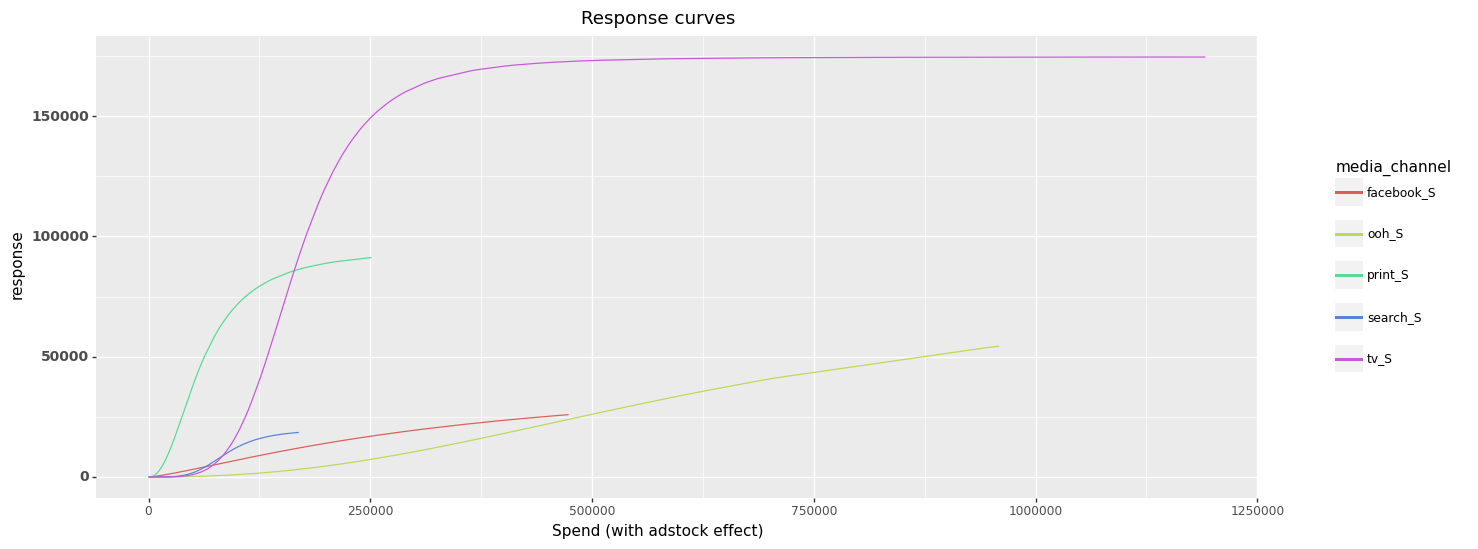

<ggplot: (133815530313)>

In [37]:
plot_multiple_spend_response_curves(media_spend_response_data)

After training the model, the impact of media spend on the response variable is visualized using response curves generated through Hill saturation transformations for each media channel. The plot displays response curves for five media channels, showcasing the relationship between weekly spend on each channel and the response over a 208-week period.

## Budget Optimization using Saturation Curves

Saturation curve-based budget optimization aims to find the ideal expenditure for each media channel, maximizing overall response while maintaining a fixed total budget over a set time. The process starts with the average spend as a baseline, and the optimizer adjusts channel budgets within predefined limits for effective constrained optimization

In [38]:
optimization_percentage = 0.2


media_channel_average_spend = result["model_data"][media_channels].mean(axis=0).values

lower_bound = media_channel_average_spend * np.ones(len(media_channels))*(1-optimization_percentage)
upper_bound = media_channel_average_spend * np.ones(len(media_channels))*(1+optimization_percentage)

boundaries = optimize.Bounds(lb=lower_bound, ub=upper_bound)

print(boundaries.lb.shape)
print(boundaries.lb)
print(media_channel_average_spend)
print(boundaries.ub)

print(f"total budget: {np.sum(media_channel_average_spend)}")

(5,)
[       89062.147        64826.912        22371.794        51495.788        35493.077]
[      111327.684        81033.639        27964.742        64369.735        44366.346]
[      133593.221        97240.367        33557.690        77243.682        53239.615]
total budget: 329062.1464875821


In [39]:
def budget_constraint(media_spend, budget):  
  return np.sum(media_spend) - budget


def saturation_objective_function(coefficients, 
                                  hill_slopes, 
                                  hill_half_saturations, 
                                  media_min_max_dictionary, 
                                  media_inputs):
    
    responses = []
    for i in range(len(coefficients)):
        coef = coefficients[i]
        hill_slope = hill_slopes[i]
        hill_half_saturation = hill_half_saturations[i]
        
        min_max = np.array(media_min_max_dictionary[i])
        media_input = media_inputs[i]
        
        hill_saturation = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).transform(X = min_max, x_point = media_input)
        response = coef * hill_saturation
        responses.append(response)
        
    responses = np.array(responses)
    responses_total = np.sum(responses)
    return -responses_total

In [40]:
media_coefficients = [feature_coefficients[media_channel] for media_channel in media_channels]
media_hill_slopes = [hill_slopes_params_best[media_channel] for media_channel in media_channels]
media_hill_half_saturations = [hill_half_saturations_params_best[media_channel] for media_channel in media_channels]

print(f"media coefficients: {media_coefficients}")
print(f"media hill slopes: {media_hill_slopes}")
print(f"media half saturations: {media_hill_half_saturations}")

#we have to pass min and max of each media channel for proper mapping for saturation hill
media_min_max = [(result["model_data"][f"{media_channel}_adstock"].min(),result["model_data"][f"{media_channel}_adstock"].max())  for media_channel in media_channels]
print(media_min_max)

media coefficients: [174638.97259910346, 79919.03697749857, 95187.76347556351, 44198.79410541945, 19817.87802702699]
media hill slopes: [4.2931188232592286, 2.2725526700406413, 2.196030975907557, 1.293484140496705, 4.082014000490807]
media half saturations: [0.13890878303803125, 0.7170422647403772, 0.23914939017559164, 0.7625292193616897, 0.5200927553940573]
[(15.025607840472022, 1191415.0972406873), (0, 959043), (0.06546543542566363, 251184.8550270213), (2.222564997785547, 473542.9735579566), (0, 169369)]


In [41]:
partial_saturation_objective_function = partial(saturation_objective_function, 
                                                media_coefficients, 
                                                media_hill_slopes, 
                                                media_hill_half_saturations, 
                                                media_min_max)


max_iterations = 100
solver_func_tolerance = 1.0e-10

solution = optimize.minimize(
      fun=partial_saturation_objective_function,
      x0=media_channel_average_spend,
      bounds=boundaries,
      method="SLSQP",
      jac="3-point",
      options={
          "maxiter": max_iterations,
          "disp": True,
          "ftol": solver_func_tolerance,
      },
      constraints={
          "type": "eq",
          "fun": budget_constraint,
          "args": (np.sum(media_channel_average_spend), )
      })


Optimization terminated successfully    (Exit mode 0)
            Current function value: -75421.16811148096
            Iterations: 38
            Function evaluations: 428
            Gradient evaluations: 37


In [42]:
print(f"initial average spend: {media_channel_average_spend}")
print(f"optimized average spend: {solution.x}")

initial average spend: [      111327.684        81033.639        27964.742        64369.735        44366.346]
optimized average spend: [      133593.221        64826.912        33557.690        61591.247        35493.077]


In [43]:
non_optimized_response = partial_saturation_objective_function(media_channel_average_spend) 
optimized_response = partial_saturation_objective_function(solution.x)

print(f"non-optimized response: {non_optimized_response}")
print(f"optimized response: {optimized_response}")

non-optimized response: -47925.01721330337
optimized response: -75421.16811148096


In [44]:
media_channel_average_spend.sum(), sum(solution.x)

(329062.1464875821, 329062.1464875821)

### Plot Optimized Budget

tv_S
	tv_S: adstock: 0.33991013367946254
	tv_S: saturation slope: 4.2931188232592286
	tv_S: half saturation k: 0.13890878303803125
	tv_S: coefficient: 174638.97259910346
	average spend: 111327, avergae non-zero spend: 251697, min spend: 0.0, max spend: 1185349.3
	average response corresponding to the average non zero spending: 26918.608710592307
	optimized spend: 133593.22
	optimized response: 49773.70


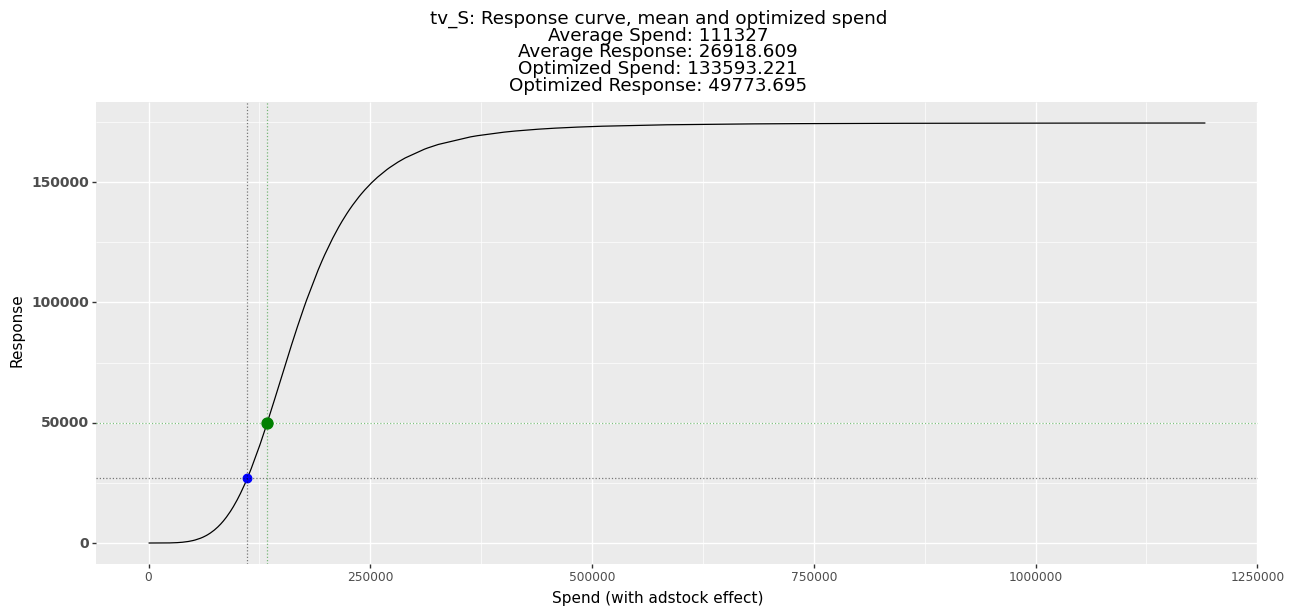


ooh_S
	ooh_S: adstock: 0.3921876135017767
	ooh_S: saturation slope: 2.2725526700406413
	ooh_S: half saturation k: 0.7170422647403772
	ooh_S: coefficient: 79919.03697749857
	average spend: 81033, avergae non-zero spend: 198294, min spend: 0, max spend: 938178
	average response corresponding to the average non zero spending: 614.7934424881807
	optimized spend: 64826.91
	optimized response: 371.39


C:\Users\RAVITE~1.KUR\AppData\Local\Temp/ipykernel_24516/3344362703.py:31: RuntimeWarning: divide by zero encountered in true_divide


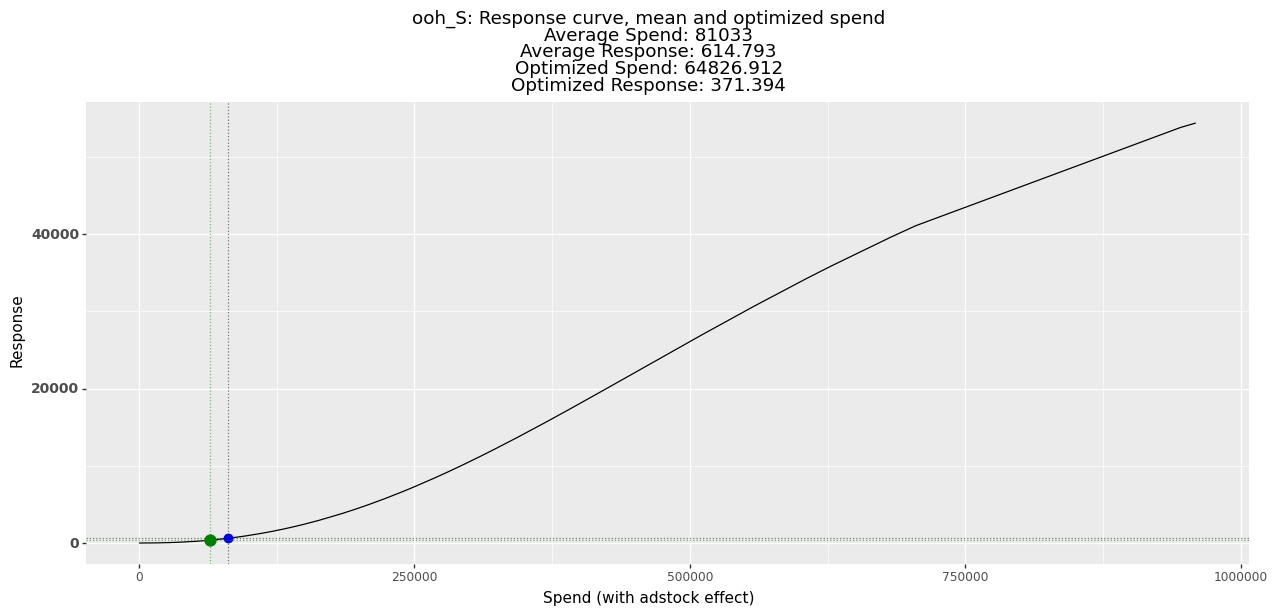


print_S
	print_S: adstock: 0.2941202914360221
	print_S: saturation slope: 2.196030975907557
	print_S: half saturation k: 0.23914939017559164
	print_S: coefficient: 95187.76347556351
	average spend: 27964, avergae non-zero spend: 66858, min spend: 0.0, max spend: 239417.333333333
	average response corresponding to the average non zero spending: 14964.956949692196
	optimized spend: 33557.69
	optimized response: 20729.93


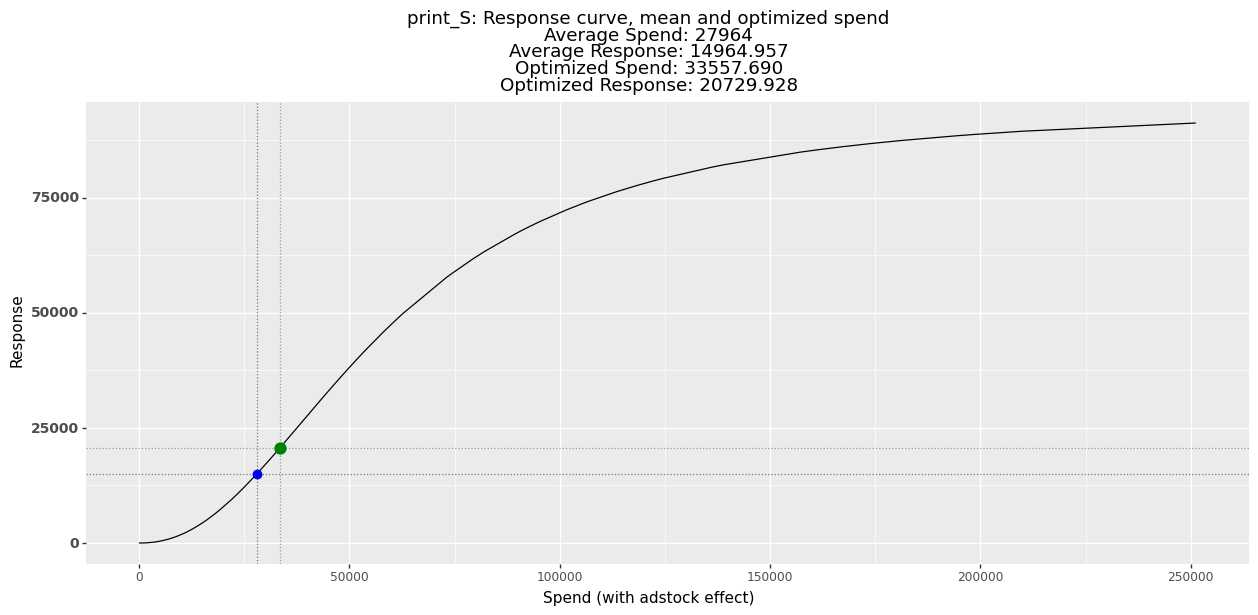


facebook_S
	facebook_S: adstock: 0.366565392117902
	facebook_S: saturation slope: 1.293484140496705
	facebook_S: half saturation k: 0.7625292193616897
	facebook_S: coefficient: 44198.79410541945
	average spend: 64369, avergae non-zero spend: 132563, min spend: 0.0, max spend: 462011.742240227
	average response corresponding to the average non zero spending: 4288.837168746324
	optimized spend: 61591.25
	optimized response: 4072.89


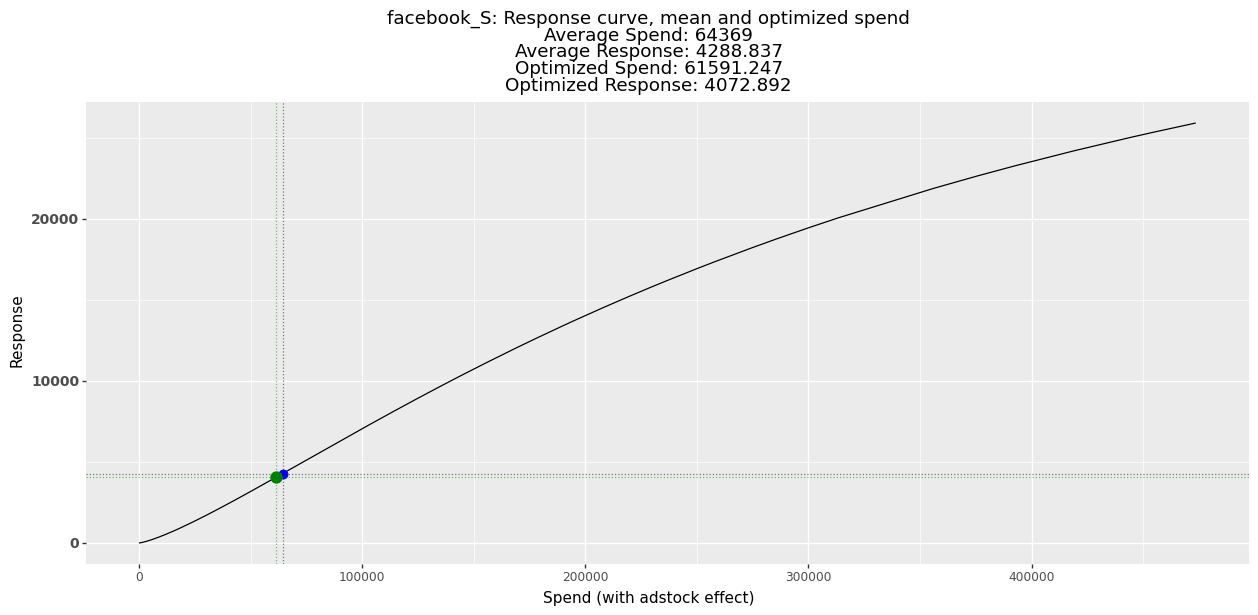


search_S
	search_S: adstock: 0.23854571538491792
	search_S: saturation slope: 4.082014000490807
	search_S: half saturation k: 0.5200927553940573
	search_S: coefficient: 19817.87802702699
	average spend: 44366, avergae non-zero spend: 52432, min spend: 0, max spend: 134100
	average response corresponding to the average non zero spending: 1136.3830835119968
	optimized spend: 35493.08
	optimized response: 473.26


C:\Users\RAVITE~1.KUR\AppData\Local\Temp/ipykernel_24516/3344362703.py:31: RuntimeWarning: divide by zero encountered in true_divide


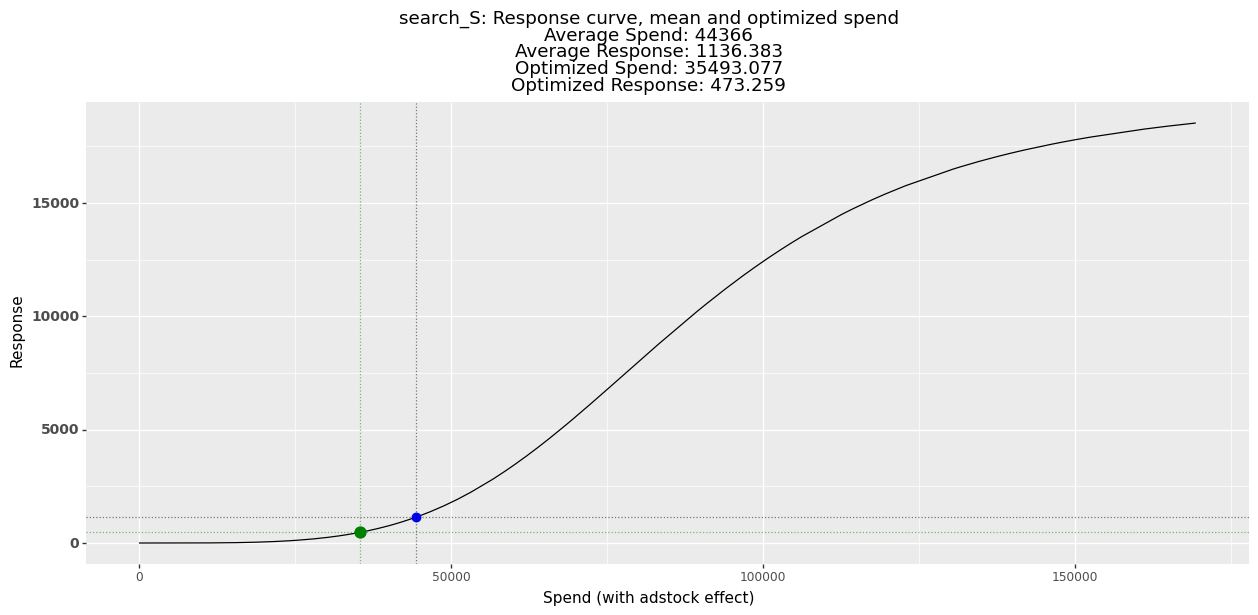

In [45]:
#dataframe for budget allocation
budget_allocation_input = pd.DataFrame()

#holds spend and response time series along with average spend/response for plotting spend-response curve
spend_response_curve_dict = {}

for i, media_channel in enumerate(media_channels):
    print(media_channel)
    
    adstock = adstock_params_best[media_channel]
    print(f"\t{media_channel}: adstock: {adstock}")

    hill_slope = hill_slopes_params_best[media_channel]
    hill_half_saturation = hill_half_saturations_params_best[media_channel]
    print(f"\t{media_channel}: saturation slope: {hill_slope}")
    print(f"\t{media_channel}: half saturation k: {hill_half_saturation}")

    coef = feature_coefficients[media_channel]
    print(f"\t{media_channel}: coefficient: {coef}")
    ######################################################

    #loc returns end index inclusive
    spendings = result["model_data"][media_channel].values
    average_nonzero_spending = int(spendings[spendings > 0].mean())
    average_spending = int(spendings.mean())
    print(f"\taverage spend: {average_spending}, avergae non-zero spend: {average_nonzero_spending}, min spend: {spendings.min()}, max spend: {spendings.max()}")

    spendings_adstocked = AdstockGeometric(alpha = adstock).fit_transform(spendings)
    
    #we have to use the same data that we used for training for proper mapping of the average spending
    average_response = coef * HillSaturation(slope_s=hill_slope, half_saturation_k=hill_half_saturation).transform(X = spendings_adstocked, x_point = average_spending)
    print(f"\taverage response corresponding to the average non zero spending: {average_response}")

    #numpy array returns end index exclusive
    spendings_saturated = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).fit_transform(spendings_adstocked)
    
    response = spendings_saturated * coef  

    spend_response_temp_df = pd.DataFrame({'spend': spendings_adstocked, 'response': response})
    
    #optimized
    optimized_spend = solution.x[i]
    optimized_response = coef * HillSaturation(slope_s=hill_slope, half_saturation_k=hill_half_saturation).transform(X = spendings_adstocked, x_point = optimized_spend)

    print(f"\toptimized spend: {optimized_spend:0.2f}")
    print(f"\toptimized response: {optimized_response:0.2f}")
    
    plot = plot_spend_response_curve(media_channel, 
                                     spend_response_temp_df, 
                                     average_spend = average_spending, 
                                     average_response = average_response, 
                                     optimized_response=optimized_response, 
                                     optimized_spend=optimized_spend)
    print(plot)

## Budget Optimization using Model

The process of optimizing the budget with the trained model is similar for models with or without saturation transformation. This approach provides flexibility to optimize the marketing mix across different time periods, including future ones.

In [46]:
optimization_period = result["model_data"].shape[0]
print(f"optimization period: {optimization_period}")


optimization_percentage = 0.2


media_channel_average_spend = optimization_period * result["model_data"][media_channels].mean(axis=0).values

lower_bound = media_channel_average_spend * np.ones(len(media_channels))*(1-optimization_percentage)
upper_bound = media_channel_average_spend * np.ones(len(media_channels))*(1+optimization_percentage)

boundaries = optimize.Bounds(lb=lower_bound, ub=upper_bound)

print(boundaries.lb.shape)
print(boundaries.lb)
print(media_channel_average_spend)
print(boundaries.ub)

print(f"total budget: {np.sum(media_channel_average_spend)}")

optimization period: 208
(5,)
[    18524926.640     13483997.600      4653333.067     10711123.869      7382560.000]
[    23156158.300     16854997.000      5816666.333     13388904.836      9228200.000]
[    27787389.960     20225996.400      6979999.600     16066685.803     11073840.000]
total budget: 68444926.46941708


In [47]:
def model_based_objective_function(model, 
                                   optimization_period, 
                                   model_features, 
                                   additional_inputs, 
                                   hill_slopes, 
                                   hill_half_saturations, 
                                   media_min_max_ranges, 
                                   media_channels, 
                                   media_inputs):
    
    media_channel_period_average_spend = media_inputs/optimization_period
    
    #transform original spend into hill transformed
    transformed_media_spends = []
    for index, media_channel in enumerate(media_channels):
        hill_slope = hill_slopes[media_channel]
        hill_half_saturation = hill_half_saturations[media_channel]
        
        min_max_spend = media_min_max_ranges[index]
        media_period_spend_average = media_channel_period_average_spend[index]
        
        transformed_spend = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).transform(np.array(min_max_spend), x_point = media_period_spend_average)
        transformed_media_spends.append(transformed_spend)
    
    transformed_media_spends = np.array(transformed_media_spends)
    
    #replicate average perio spends into all optimization period
    replicated_media_spends = np.tile(transformed_media_spends, optimization_period).reshape((-1, len(transformed_media_spends)))
    
    #add _hill to the media channels
    media_channels_input = [media_channel + "_hill" for media_channel in media_channels]
    media_channels_df = pd.DataFrame(replicated_media_spends, columns = media_channels_input)
    
    #additional_data = result["model_train_data"][control_features + [organic_channel+"_hill" for organic_channel in organic_channels]]
    
    #prepare data for predictions
    new_data = pd.concat([additional_inputs, media_channels_df], axis = 1)[model_features]
    
    predictions = model.predict(X = new_data)
    
    total_sum = predictions.sum()
    
    return -total_sum


In [48]:
media_channel_average_spend

array([    23156158.300,     16854997.000,      5816666.333,     13388904.836,      9228200.000])

In [49]:
model = result["model"]
model_features = result["model_features"]
print(f"model features: {model_features}")
additional_inputs = result["model_train_data"][control_features + [organic_channel+"_hill" for organic_channel in organic_channels]]
hill_slopes = hill_slopes_params_best
hill_half_saturations = hill_half_saturations_params_best
media_min_max_ranges = media_min_max

print(f"media channels: {media_channels}")

model features: ['trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S_hill', 'ooh_S_hill', 'print_S_hill', 'facebook_S_hill', 'search_S_hill', 'newsletter_hill']
media channels: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']


In [50]:
partial_model_objective_function = partial(model_based_objective_function, 
                                           model, 
                                           optimization_period, 
                                           model_features, 
                                           additional_inputs, 
                                           hill_slopes, 
                                           hill_half_saturations, 
                                           media_min_max_ranges, 
                                           media_channels)


max_iterations = 200
solver_func_tolerance = 1.0e-10

model_based_optimization_solution = optimize.minimize(
      fun=partial_model_objective_function,
      x0=media_channel_average_spend,
      bounds=boundaries,
      method="SLSQP",
      jac="3-point",
      options={
          "maxiter": max_iterations,
          "disp": True,
          "ftol": solver_func_tolerance,
      },
      constraints={
          "type": "eq",
          "fun": budget_constraint,
          "args": (np.sum(media_channel_average_spend), )
      })


Optimization terminated successfully    (Exit mode 0)
            Current function value: -374929650.88659513
            Iterations: 51
            Function evaluations: 551
            Gradient evaluations: 49


In [51]:
model_based_optimization_solution

     fun: -374929650.88659513
     jac: array([          -1.144,           -0.013,           -1.061,           -0.078,           -0.053])
 message: 'Optimization terminated successfully'
    nfev: 551
     nit: 51
    njev: 49
  status: 0
 success: True
       x: array([    27787389.960,     13483997.600,      6979999.600,     12810979.309,      7382560.000])

In [52]:
print(f"initial spend for period of {optimization_period} weeks: {media_channel_average_spend}")
print(f"optimized spend for period of {optimization_period} weeks: {model_based_optimization_solution.x}")


print(f"initial average spend: {media_channel_average_spend/optimization_period}")
print(f"optimized average spend: {model_based_optimization_solution.x/optimization_period}")

initial spend for period of 208 weeks: [    23156158.300     16854997.000      5816666.333     13388904.836      9228200.000]
optimized spend for period of 208 weeks: [    27787389.960     13483997.600      6979999.600     12810979.309      7382560.000]
initial average spend: [      111327.684        81033.639        27964.742        64369.735        44366.346]
optimized average spend: [      133593.221        64826.912        33557.690        61591.247        35493.077]


Optimizing budget spend in marketing mix modeling is crucial for marketers as it enables them to allocate resources effectively, maximizing the impact of marketing efforts and achieving business objectives.